# Libraries

In [1]:
import os
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import math
import logging

# Data loading and exploration

In [2]:
IMG_SHAPE  = 224
batch_size = 32
random_seed = 9

In [3]:
fpath = './Dataset_RemovedBG'
categories = os.listdir(fpath)
categories.pop(1)
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))

List of categories =  ['totally_green', 'yellow_with_brown_spots', 'yellow_with_green_tips'] 

No. of categories =  3


In [4]:
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SHAPE, IMG_SHAPE))
            img_array = Image.fromarray(img, 'RGB')

            img_lst.append(np.array(img_array))

            labels.append(index)
    return img_lst, labels

images, labels = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))

No. of images loaded =  288 
No. of labels loaded =  288
<class 'list'> <class 'list'>


In [5]:
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (288, 224, 224, 3) 
Labels shape =  (288,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


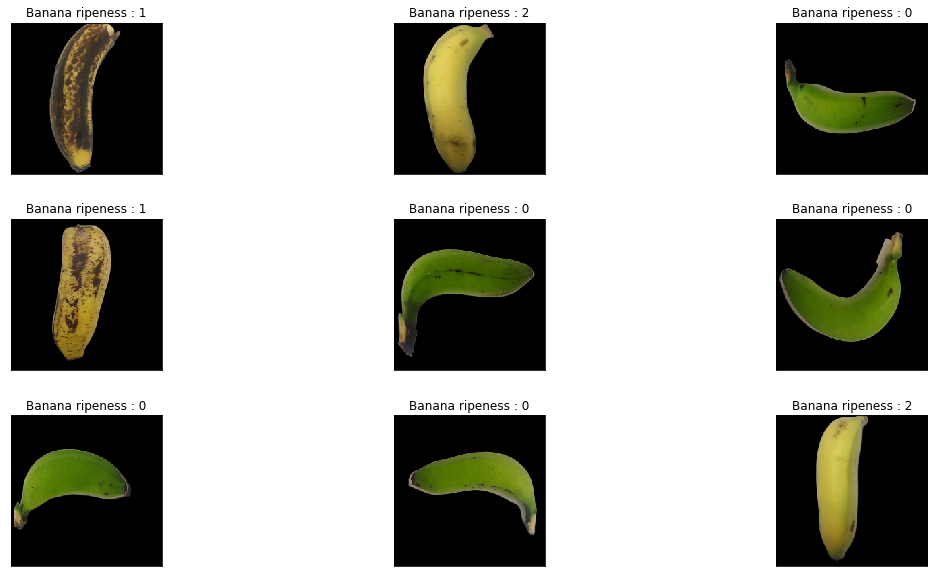

In [6]:
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('Banana ripeness : {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    
display_rand_images(images, labels)

# Prepare data for training the CNN model

In [7]:
#1-step in data shuffling

#get equally spaced numbers in a given range
n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)

#shuffle all the equally spaced values in list 'n'
np.random.seed(random_seed)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

'n' values before shuffling =  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238

In [8]:
#2-step in data shuffling

#shuffle images and corresponding labels data in both the lists
images = images[n]
labels = labels[n]

print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",labels.shape)

Images shape after shuffling =  (288, 224, 224, 3) 
Labels shape after shuffling =  (288,)


In [9]:
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (288, 224, 224, 3)


In [10]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = random_seed)

x_val = x_train[:58]
y_val = y_train[:58]
x_train = x_train[58:]
y_train = y_train[58:]

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

print("\nx_val shape = ",x_val.shape)
print("y_val shape = ",y_val.shape)

x_train shape =  (172, 224, 224, 3)
y_train shape =  (172,)

x_test shape =  (58, 224, 224, 3)
y_test shape =  (58,)

x_val shape =  (58, 224, 224, 3)
y_val shape =  (58,)


In [11]:
##One-hot-encode
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)
y_val = to_categorical(y_val, 3)

# Define CNN model

In [12]:
pre_trained_model = tf.keras.applications.MobileNetV2(input_shape=x_train[0].shape, include_top=False, weights="imagenet")

In [13]:
for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False

input_1
Conv1_pad
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
bloc

In [14]:
last_layer = pre_trained_model.get_layer('out_relu')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)
model = tf.keras.Model(pre_trained_model.input, x)

# Train model

In [15]:
model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['acc'])

In [16]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [17]:
steps_per_epoch = (x_train.shape[0]//batch_size)
validation_steps = (x_val.shape[0] // batch_size)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

In [18]:
x_train.shape,y_train.shape

((172, 224, 224, 3), (172, 3))

In [19]:
start_time = time.time()

history = model.fit(x_train, y_train,
    steps_per_epoch=steps_per_epoch,
    epochs = 50,
    validation_data=(x_val, y_val),
    validation_steps=validation_steps,
    batch_size = batch_size,
    callbacks=[es],
    verbose=1)

logging.basicConfig(filename="CNN-basedTL_MobileNet_log.txt", level=logging.INFO)
logging.info("Training Execution Time:" + time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))

Epoch 1/50
5/5 [==============================] - 3s 556ms/step - acc: 0.4125 - loss: 8.0092 - val_loss: 0.1633 - val_acc: 0.9688
Epoch 2/50
5/5 [==============================] - 2s 348ms/step - acc: 0.7714 - loss: 1.1477 - val_loss: 0.0137 - val_acc: 1.0000
Epoch 3/50
5/5 [==============================] - 1s 291ms/step - acc: 0.9500 - loss: 0.1868 - val_loss: 0.0056 - val_acc: 1.0000
Epoch 4/50
5/5 [==============================] - 2s 308ms/step - acc: 0.9786 - loss: 0.0376 - val_loss: 0.3191 - val_acc: 0.9688
Epoch 5/50
5/5 [==============================] - 1s 299ms/step - acc: 0.9714 - loss: 0.1730 - val_loss: 0.2840 - val_acc: 0.9688
Epoch 6/50
5/5 [==============================] - 2s 310ms/step - acc: 0.9786 - loss: 0.2385 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 7/50
5/5 [==============================] - 2s 374ms/step - acc: 0.9937 - loss: 0.0062 - val_loss: 1.1511e-06 - val_acc: 1.0000
Epoch 8/50
5/5 [==============================] - 2s 348ms/step - acc: 0.9857 - loss: 

In [20]:
model_json = model.to_json()
with open("CNN-based TL model/MobileNet_Banana_Classifier.json", "w") as json_file:
    json_file.write(model_json)
model.save("CNN-based TL model/MobileNet_Banana_Classifier.h5")
print("Saved model to disk")
model.save_weights("CNN-based TL model/MobileNet_Banana.h5")

Saved model to disk


# Evaluation model

In [21]:
start_time = time.time()

loss, accuracy = model.evaluate(x_test,y_test,batch_size=batch_size)
print('test_loss: %.2f' % (loss * 100.0))  
print('test_accuracy: %.2f' % (accuracy * 100.0))

logging.info("Evaluation Execution Time: " + time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
logging.info("test_loss:" + str(loss))
logging.info("test accuracy:" + str(accuracy))

2/2 [==============================] - 0s 142ms/step - acc: 0.9828 - loss: 0.0650
test_loss: 6.50
test_accuracy: 98.28


In [22]:
model_probs = model.predict(x_test,batch_size=batch_size,verbose=0)
# predict crisp classes for test set
model_classes = np.argmax(model_probs,axis=1)
# reduce to 1d array
model_probs = model_probs[:, 0]

y_test_reduced = np.argmax(y_test,axis=1)
 
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_reduced, model_classes)*100
# precision tp / (tp + fp)
precision = precision_score(y_test_reduced, model_classes, average='weighted')*100
# recall: tp / (tp + fn)
recall = recall_score(y_test_reduced, model_classes, average='weighted')*100
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_reduced, model_classes, average='weighted')*100

print('Accuracy: %.2f' % accuracy)
print('F1 score: %.2f' % f1)
print('Precision: %.2f' % precision)
print('Recall: %.2f' % recall)

logging.info('Accuracy: %.2f' % accuracy)
logging.info('F1 score: %.2f' % f1)
logging.info('Precision: %.2f' % precision)
logging.info('Recall: %.2f' % recall)

Accuracy: 98.28
F1 score: 98.29
Precision: 98.38
Recall: 98.28


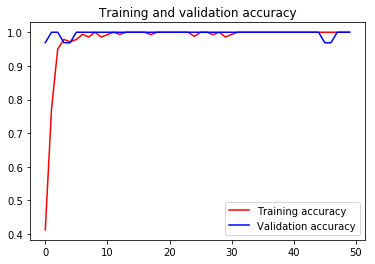

In [23]:
accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.savefig("Training and validation accuracy - CNN-based TL.png")
plt.show()